In [3]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.spatial import distance, KDTree
import numpy as np

%matplotlib inline

In [280]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth = 100

# Function Cell

In [124]:
def one_hot_encode_holds(df):
    """
    Takes in a dataframe and one hot encodes all the holds to create holds vector for each problem
    """
    
    holds = [] # Create a list of A1 - K18
    
    for x in range(0,198):
        num = x % 18 + 1
        alph = chr(x // 18 + 65)
        holds.append(f"{alph}{num}")
    
    for hold in holds:
        one_hot = []
        
        # Make a binary list if each hold in holds is contained in any column
        
        for index, row in df.iterrows():
            if hold+"'" in df['start'][index] or hold+"'" in df['end'][index] or hold+"'" in df['moves'][index]:
                one_hot.append(1)
            else: one_hot.append(0)
            
        df[hold] = one_hot
        print(hold)
        
    return df

# Creating a numeric target column based off of setter rating
grading_dict = {'5+':5,
                '6A':6,
                '6A+':7,
                '6B': 8,
                '6B+':9,
                '6C':10,           
                '6C+':11,
                '7A':12,
                '7A+':13,
                '7B': 14,
                '7B+':15,
                '7C': 16,
                '7C+': 17,
                '8A': 18,
                '8A+': 19, 
                '8B':20,
                '8B+':21}

vermin_dict = {'5+':2,
                '6A':3,
                '6A+':3,
                '6B': 4,
                '6B+':4,
                '6C':5,           
                '6C+':5,
                '7A':6,
                '7A+':7,
                '7B': 8,
                '7B+':8,
                '7C': 9,
                '7C+': 10,
                '8A': 11,
                '8A+': 12, 
                '8B':13,
                '8B+':14}

def grade_to_num(grade):
    return grading_dict[grade]

def grade_to_vermin(grade):   
    return vermin_dict[grade]

def move_distances(row_number):
    """
    Enter in a row index and this will spit out:
    move_length_avg, move_length_crux
    
    Currently has a 1.25 multiplier for vertical movements
    
    """

    start = re.findall(r'\d+', str(df['start_coords'][row_number]))
    moves = re.findall(r'\d+', str(df['move_coords'][row_number]))
    ends = re.findall(r'\d+', str(df['end_coords'][row_number]))
    print(f"Row Number{row_number}")
    all_holds = []

    for x in [start, moves, ends]: # I have a 1.25 multiplier for going vertical
        all_holds.append([(int(x[i]),1.25*int(x[i+1])) for i in range(0,len(x),2)])

    min_dist = [(0,0),1000]

    low_holds_count = 0

    for a in all_holds[0]: # in all start holds
        for b in all_holds[1]: # in all move holds
            if a[1] < b[1]:
                low_holds_count += 1
                all_holds[1].remove(b)
            
    for a in all_holds[0]: # 
        for b in all_holds[1]:
            if distance.euclidean(a,b) < min_dist[1]:
                min_dist = ((b), distance.euclidean(a,b))

    min_finsih_dist = [(0,0),1000]
    for c in all_holds[1]: # in all start holds
        for d in all_holds[2]:
            if distance.euclidean(c,d) < min_finsih_dist[1]:
                min_finsih_dist = ((d), distance.euclidean(c,d))
                second_ending = c

    min_dist = list(min_dist)

    for x in range(len(all_holds[1])-1):

        all_holds[1].remove(min_dist[-2])

        if min_dist[-2] == second_ending:
            min_dist.append(min_finsih_dist[0])
            min_dist.append(min_finsih_dist[1])
            break
        else:
            list_of_mins = [distance.euclidean(min_dist[-2],x) for x in all_holds[1]]

            min_dist.append(all_holds[1][list_of_mins.index(min(list_of_mins))])
            min_dist.append(min(list_of_mins))

    move_lengths = min_dist[1:len(min_dist):2]
    move_length_avg = np.mean(move_lengths)
    move_length_crux = max(move_lengths)

    print(low_holds_count)
    
    return move_length_avg, move_length_crux, min_dist, low_holds_count


def get_move_df(df):
    """
    Will take in a dataframe and return a df with movement cols:
    problem_avg_mov and problem_max_mov
    """
    problem_avg = []
    problem_crux = []
    problem_moves = []
    num_holds_under_start = []

    for row_index in range(len(df)):
        row_avg, row_max, row_moves, num_holds_under = move_distances(row_index)
        problem_avg.append(row_avg)
        problem_crux.append(row_max)
        problem_moves.append(row_moves)
        num_holds_under_start.append(num_holds_under)
        

    df['problem_avg_mov'] = problem_avg
    df['problem_max_mov'] = problem_crux
    df['problem_min_dist'] = problem_moves
    df['num_holds_under_start'] = num_holds_under_start
    

    return df

def move_distances(row_number):
    """
    Enter in a row index and this will spit out:
    move_length_avg, move_length_crux
    
    Currently has a 1.25 multiplier for vertical movements
    
    """

    start = re.findall(r'\d+', str(df['start_coords'][row_number]))
    moves = re.findall(r'\d+', str(df['move_coords'][row_number]))
    ends = re.findall(r'\d+', str(df['end_coords'][row_number]))
    print(f"Row Number{row_number}")
    all_holds = []

    for x in [start, moves, ends]: # I have a 1.25 multiplier for going vertical
        all_holds.append([(int(x[i]),1.25*int(x[i+1])) for i in range(0,len(x),2)])

    min_dist = [(0,0),1000]

    low_holds_count = 0

    for a in all_holds[0]: # in all start holds
        for b in all_holds[1]: # in all move holds
            if a[1] < b[1]:
                low_holds_count += 1
                all_holds[1].remove(b)
            
    for a in all_holds[0]: # 
        for b in all_holds[1]:
            if distance.euclidean(a,b) < min_dist[1]:
                min_dist = ((b), distance.euclidean(a,b))

    min_finsih_dist = [(0,0),1000]
    for c in all_holds[1]: # in all start holds
        for d in all_holds[2]:
            if distance.euclidean(c,d) < min_finsih_dist[1]:
                min_finsih_dist = ((d), distance.euclidean(c,d))
                second_ending = c

    min_dist = list(min_dist)

    for x in range(len(all_holds[1])-1):

        all_holds[1].remove(min_dist[-2])

        if min_dist[-2] == second_ending:
            min_dist.append(min_finsih_dist[0])
            min_dist.append(min_finsih_dist[1])
            break
        else:
            list_of_mins = [distance.euclidean(min_dist[-2],x) for x in all_holds[1]]

            min_dist.append(all_holds[1][list_of_mins.index(min(list_of_mins))])
            min_dist.append(min(list_of_mins))


    # min_finish = 9999
    # for w in all_holds[2]:
    #     if distance.euclidean(min_dist[-2],w) < min_finish:
    #         min_finish = distance.euclidean(min_dist[-2],w)
    #         hold = w

    # min_dist.append(hold)
    # min_dist.append(min_finish)

    move_lengths = min_dist[1:len(min_dist):2]
    move_length_avg = np.mean(move_lengths)
    move_length_crux = max(move_lengths)

    print(low_holds_count)
    
    return move_length_avg, move_length_crux, min_dist, low_holds_count


def get_move_df(df):
    """
    Will take in a dataframe and return a df with movement cols:
    problem_avg_mov and problem_max_mov
    """
    problem_avg = []
    problem_crux = []
    problem_moves = []
    num_holds_under_start = []

    for row_index in range(len(df)):
        row_avg, row_max, row_moves, num_holds_under = move_distances(row_index)
        problem_avg.append(row_avg)
        problem_crux.append(row_max)
        problem_moves.append(row_moves)
        num_holds_under_start.append(num_holds_under)
        

    df['problem_avg_mov'] = problem_avg
    df['problem_max_mov'] = problem_crux
    df['problem_min_dist'] = problem_moves
    df['num_holds_under_start'] = num_holds_under_start
    

    return df

# COUNTRY DICTIONARY FOR CLEANING COUNTRY COLUMNS
country_dict = {
    "UNITED STATES OF AMERICA": ['USA','UNITED STATES','USA','US','AMERICA','NEW JERSEY','ARIZONA','UNIYED STATES',
                                'UNITED STATES OF AMAERICA','TEXAS','STATES','CALIFORNIA','QUEENS','UNITED STARTED',
                                'U.S.','U.S.A.','NY','NC','CO','WA','NEW YORK','IN','HAMILTON','DOUGLAS','EEUU','U.S.A'
                                ,'USS','UNITED STATES​'],
    "JAPAN": ['JJAJAPJAPAJAPANJAPANJAPAN','JPN','日本','JAPANN'],
    "GERMANY": ['DEUTSCHLAND', 'DE', 'GER','GERMAY','BERLIN','GERMMONEY','KARLSRUHE','SAARLAND','GERMANY​'],
    "CANADA": ['ALBERTA','CANDA','ON',"CAN"],
    "NORWAY": ['NORGE','NIRWAY','HERØY','NORWSY','NO'],
    "UNITED KINGDOM": ['UK','ENGLAND','YORKSHIRE', 'WEST YORKS','CUMBRIA','TYNE AND WEAR','WALES','GUERNSEY','MIDLOTHIAN',
                      'SOTLAND','WEST YORKSHIRE','SHROPSHIRE','TYNE & WEAR','GREAT BRITAIN','EDINBURGH','COTLAND','BRITAIN',
                      'FLINTSHIRE','LANARKSHIRE','CHESHIRE','ENGERLAND','SCOTLAND'],
    "ITALY": ['ITALIA','SONDRIO','PIEMONTE','PINEROLO','TRENTO'],
    "HONG KONG": ['HONGKONG', 'HK','HONG KONG SAR','HONG KONG SAR CHINA','SAR'],
    "SPAIN": ["ESPAÑA",'CATALUNYA','ESPAÑ','MURCIA','MADRID'],
    "SWITZERLAND": ['SUISSE','SCHWEIZ','SWIZERLAND','TREYVAUX'],
    "ROMANIA": ['ROMÂNIA'],
    "POLAND": ['POLSKA','PL'],
    "THE NETHERLANDS":['NEDERLAND','NL','NETHERLANDS'],
    "DENMARK": ["DANMARK"],
    "HUNGARY": ['MAGYARORSZÁG'],
    "CHILE": ['CH'],
    "SWEDEN": ['SVERIGE','SWEEDEN'],
    "BRAZIL": ['BRASIL'],
    "AUSTRALIA": ['AUS','AUSTRALIA​'],
    "AUSTRIA": ['ÖSTERREICH','VORARLBERG'],
    "RUSSIA": ['RUSS','RUS','RUSSIAN FEDERATION'],
    "SOUTH KOREA": ['REPUBLIK OF KOREA','YOSU','KR','KOREA'],
    "LUXEMBOURG": ['LUXEMBURG']
}
def country_text_cleaner(df):
    """
    Will clean known country misspellings etc
    """
    for row_no in range(len(df)): #iterate through each row

        if row_no % 100 == 0: print(row_no)

        for key in country_dict.keys(): # check each country name

            if df['country'][row_no] in country_dict[key]: # against the values it could be
                df['country'][row_no] = key # set if janky name in the values
    return df

# Create Selenium instance of Moonboard.com w/ Login information

In [125]:
%run PaS5W0RD.ipynb

def login_to_moonboard(username, password):
    '''
    
    Creates a selenium instance of a moonboard account problem page
        
    '''
    driver = webdriver.Chrome()
    driver.get('https://www.moonboard.com/Account/Login')
    
    user = driver.find_element_by_css_selector('input[type=text]') # Types the provided Username
    user.send_keys("ProblemGenerator")
        
    password = driver.find_element_by_css_selector('input[type=password]') # Type the provided password
    password.send_keys(payload['password'])
    
    return driver

In [126]:
driver = login_to_moonboard(username = payload['username'], password = payload['password'])

# Navigate => Problems => View => Sort = Most Repeats

In [127]:
soup = BeautifulSoup(driver.page_source, "lxml")

problem = soup.find_all('div', {'class':'problem-inner'})

# Following cell will navigate, scrape individual problems, and store them in a python dictionairy

In [133]:

data_dict = {
    'ID': [],
    'title': [],
    'username': [],
    'repeats': [],
    'setter_rating': [],
    'user_rating': [],
    'footwork': [],
    'steepness': [],
    'stars': []
}

for page in range(1,9):
    
    soup = BeautifulSoup(driver.page_source, "lxml")
    problem = soup.find_all('div', {'class':'problem-inner'})
    problem_id = soup.find('div', {'class':'k-grid-content'}).find_all('tr')
    
    for x in range(15):
        
        data_dict['ID'].append(problem_id[x]['data-uid'])
    
        problem_list = list(filter(None,problem[x].text.split("    ")))

        data_dict['title'].append(problem_list[0][1:])
        data_dict['username'].append(problem_list[1])
        data_dict['repeats'].append((problem_list[2].split(' ')[1]))
        data_dict['setter_rating'].append(problem_list[3].split(' ')[0])
        data_dict['user_rating'].append(problem_list[3].split(' ')[-1].replace(")",""))
        data_dict['footwork'].append(problem_list[4])
        data_dict['steepness'].append((problem_list[5][0:2]))

        if problem[x].find_all('li')[2].img.attrs['src'] == '/Content/images/star.png':
            data_dict['stars'].append(3)
        elif problem[x].find_all('li')[1].img.attrs['src'] == '/Content/images/star.png':
            data_dict['stars'].append(2)
        elif problem[x].find_all('li')[0].img.attrs['src'] == '/Content/images/star.png':
            data_dict['stars'].append(1)
        else:
            data_dict['stars'].append(0)
            
        driver.find_elements_by_class_name('problem-inner')[x].click()
        
        
        time.sleep(0.5)
        
        
            
    page += 1
    
    if (page-1) % 3 != 0:
        #driver.find_elements_by_class_name('k-link')[5].click()
        driver.find_element_by_link_text(str(page)).click()
    elif page == 4:
        driver.find_element_by_partial_link_text("...").click() #for page 4
    else:
        driver.find_elements_by_class_name('k-link')[5].click()
    
    
    time.sleep(12)



In [113]:
sel_df = pd.DataFrame.from_dict(data_dict)
sel_df.head()

,ID,footwork,repeats,setter_rating,stars,steepness,title,user_rating,username
0,305495,Feet follow hands,2657,6A+,3,40,IN ON THE ACTION,6A+,Fox
1,305454,Feet follow hands,2228,6A+,3,40,"TO JUG, OR NOT TO JUG...",6A+,Kyle Knapp
2,305483,Feet follow hands,1977,6A+,3,40,BLEAK HOUSE,6A+,Ben Moon
3,309231,Feet follow hands,1965,6A+,3,40,WARM UP ON BIG ONES,6A+,blairman
4,308275,Feet follow hands,1800,6B,3,40,VRTW 2,6B,Adrian Mamina-chiriac


# OR, OR, OR you could just scrape the whole problems dataset at once

In [19]:

page = 1
pagesize = 100
cookie = "_ga=GA1.2.1760642357.1528386887; _gid=GA1.2.898996210.1530272951; __RequestVerificationToken=xHqo2dOMQ-DBasDJjYbURnTGU0gY8e_gmK2dsu09SFVmhEkJ0pOGKWkpOAKOEBmBeIvZDVEKojHyushYhr7bbXjfBsPHbThPPI9DmY4SCfQ1; _MoonBoard=EKGIBHeCRDrfj-WwRu4JdV4QT5Yn3oa_cIVoZvkHapDqmk2XpY7ba24F4HmIXdgEHRVHhHklnvWFkriYDABx7gZiFjHu4Y4AkGe13FomiSXfz1qpS83eEN5s_TPJijP5XTf4rIQFQa2zfL6u3bB78ShAjLqXEewMw68hT5425MhPBWlqEenZKTXduJqWfQMwatuN48WMs50onn7dHD0LpsZ5x5ne8J7OThS0Z0Kqtr2anc4TTT7JTWkH4Z4QbCkz7DAtKyI5Ujfe8toxDOuFYLrl3822s5nCk9fnWqBdEPSIrwGRZC6pp6DVCCD7k9ovUCGeZZsEG48YiF_d5ofFlSluvKeOWrKeJ5aKkzdxlaBR8qpqvLS4q0F0d8em8YSw9xXwXca6B678SviHefwvdXop1wMFwj7-NUwzgvCG5HMzwiXbojThF-HJJAKHoV-IYmh_l5G4pflkhjBAlMIFxOCSjSB7XnMicyZVmeOrtVXBRtLINkLrONW4Q8eD-WlolZtcwi5JSHI5p_6Dw9NP5mQRo7CZcyueOvP1W8i7NpE"

r = requests.post("https://www.moonboard.com/Problems/GetProblems",
                headers = {"Content-Type":"application/x-www-form-urlencoded; charset=UTF-8",
                           "Cookie": cookie},
                data = "sort=&page=" + str(page) + "&pageSize=" + str(pagesize) + "&group=&filter=")

print(page, r.status_code, r.reason) 

#jstruct = json.loads(r.text)

1 200 OK


In [74]:
%%time
df_dict = {}

for x in range(1,94): #iterate through the 89 pages of 100 problems => 8874 problems currently
    page = x
    pagesize = 100
    cookie = "_ga=GA1.2.1760642357.1528386887; _gid=GA1.2.1808950873.1531151642; __RequestVerificationToken=xHqo2dOMQ-DBasDJjYbURnTGU0gY8e_gmK2dsu09SFVmhEkJ0pOGKWkpOAKOEBmBeIvZDVEKojHyushYhr7bbXjfBsPHbThPPI9DmY4SCfQ1; _MoonBoard=MyL3TTVYGYDuEvkxPI00G4kSggYjyYYxaphxI-o6K_ZZM4pHQiPL-9ug-uIayhP6TzuNyKU6343vxu17VdgDdpd5d5iw9BI-Q53CmB6rsen1WKmkM8iwhstfZvvHLrIEIDtlnZ6Qe0qajZvswPduKonxN03xgYBONGAt_sQbtObKCaCJjWoFM2YxyEAW-1ZYZHJ-QYhTPPt8HcVEapdOD_E7F4q71DV1ZIAyJATpal7YXSF8iKvaBOMqX8hhQfna2PnILRCMDoLf815eHcdUhLbws5N1WmJaLtvJBlh7xbQqkN6087zuWkmrekBNpvo74GK3HTsShsj2qnXv6BIa2wUgEou2TZuksRPNOGT5IizFAB8JI8WTgFtp6EmRHsju5HaD6Thy3CbqgTeco8pmAC1HrKlI2ZQR_4Cxo9cBRsscZEKUncQhVGeit70xKngpsfflyMuRFNVWECSNjWQHoZSlHlCS1gsHQGZnIXSi5VuFWtdCKEr06_FFaJ-KjHsi4s38BCOpIJzzU9h0hegYRw"
    # Will need to replace cookies with pertinent values from headers tab
    r = requests.post("https://www.moonboard.com/Problems/GetProblems",
                    headers = {"Content-Type":"application/x-www-form-urlencoded; charset=UTF-8",
                               "Cookie": cookie},
                    data = "sort=&page=" + str(page) + "&pageSize=" + str(pagesize) + "&group=&filter=")
    
    if page % 10 == 0:
        print(page, r.status_code, r.reason) 

    jstruct = json.loads(r.text)     

    for problem in jstruct['Data']: # Will be 100 problems per page
        moves = []
        start = []
        end = []
        coords = []
        coords_start = []
        coords_end = []
        
        
        #Get the moves and distinguish if the move is start | end | inbetween
        for move in problem['Moves']:
            if move['IsStart']:
                start.append(move['Description'])
            elif move['IsEnd']:
                end.append(move['Description'])
            else:
                moves.append(move['Description'])
        
        #Pulls out the coordinates of each hold in the image
        for coord in problem['Locations']:
            if coord['Color'] == '0x00FF00':
                coords_start.append([coord['X'],coord['Y']])
            elif coord['Color'] == '0xFF0000':
                coords_end.append([coord['X'],coord['Y']])
            else:
                coords.append([coord['X'],coord['Y']])

        #Populate Dictionary with values from json
        df_dict[problem['Id']] = {
            'problem_name': problem['Name'],
            'setter_grade': problem['Grade'],
            'user_grade': problem['UserGrade'],
            'date': problem['DateTimeString'],
            'method': problem['Method'],
            'rating': problem['Rating'],
            'user_rating': problem['UserRating'],
            'repeats': problem['Repeats'],
            'steepness': problem['MoonBoardConfiguration']['Description'],
            'setter': problem['Setter']['Nickname'],
            'city': problem['Setter']['City'],
            'country': problem['Setter']['Country'],
            'setup': problem['Holdsetup']['Description'],
            'start': start,
            'end': end,
            'moves': moves,    
            'holds': len(moves)+len(end)+len(start),
            'start_coords': coords_start,
            'end_coords': coords_end,
            'move_coords': coords
        }

In [75]:
len(df_dict) #number of problems scraped

In [76]:
df = pd.DataFrame.from_dict(df_dict, orient='index') 

In [286]:
# This cell will call df altering functions 

df = df.reset_index().rename(index=str, columns={"index": "prob_id"}) # Reset index and name problem ID column

df = one_hot_encode_holds(df) # Makes all the hold vector cols

df = get_move_df(df) # Creates moved dist ratings

df['target'] = df['setter_grade'].apply(grade_to_num) # Creates fontainbleau target col

user_diff = df.dropna(subset = ['user_grade'], axis = 0)[(df['user_grade'] != df['setter_grade'])]
         # Finds entries where setter grade is different from user_grade

df['target_vermin'] = df.apply(lambda x: grade_to_vermin(x['user_grade']) 
         if x[0] in user_diff.index  
         else grade_to_vermin(x['setter_grade']),
         axis = 1)  #Target Vermin column created

df['steepness_dummy'] = pd.get_dummies(df['steepness'],drop_first=True) # steepness dummy col

df = pd.concat([df,pd.get_dummies(df['method'], drop_first=True)], axis=1)

df["num_start_holds"] = df['start'].apply(len)/6 # get the number of starting holds

df = kd_tree_features(df)

df = country_text_cleaner(df)


# CLEANING HORRIBLE PROBLEMS

In [443]:
df = df[df['problem_name'] != "GOODOSHER"] # joke submission

In [104]:
#df = pd.read_csv("df_newest.csv")

In [117]:
#df.to_csv('df_newest.csv')

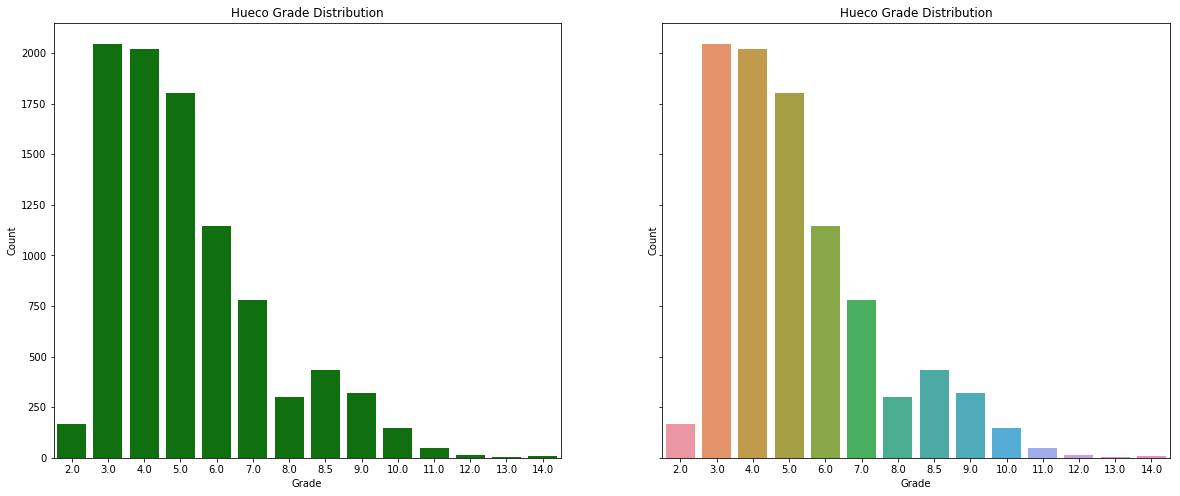

In [209]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,8), sharey=True);

sns.barplot(x = df.groupby('target_vermin').sum().index,y =df.groupby('target_vermin').count()['problem_name'],
           ax=ax[0], color="g");

ax[0].set_title("Hueco Grade Distribution");
ax[1].set_title("Hueco Grade Distribution");

ax[0].set(xlabel='Grade', ylabel='Count')

sns.barplot(x = df.groupby('target_vermin').sum().index,y =df.groupby('target_vermin').count()['problem_name'], ax=ax[1]);
ax[1].set(xlabel='Grade', ylabel='Count');

plt.tight_layout;

plt.savefig("Grade_dist")


In [287]:
df['holds'].value_counts().sort_index() # Distribution of the number of holds per problem

In [288]:
df['setter_grade'].value_counts()

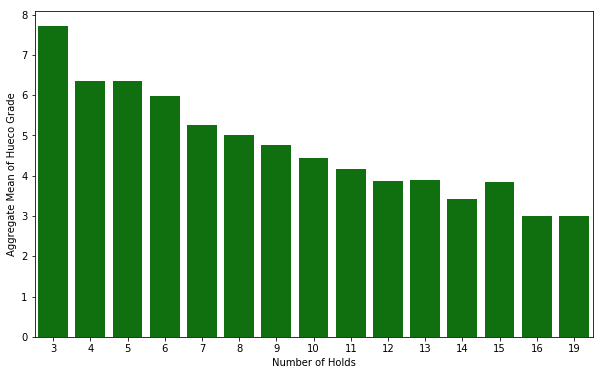

In [245]:
plt.figure(figsize=(10,6))
sns.barplot(x = pd.DataFrame(df['holds'].value_counts().sort_index()).index,
            y = pd.DataFrame(df.groupby('holds').mean()['target_vermin'])['target_vermin'],
           color = 'g')

plt.ylabel("Aggregate Mean of Hueco Grade")
plt.xlabel("Number of Holds");

plt.savefig('Images/holds_dist')


In [326]:
pd.DataFrame(df['holds'].value_counts().sort_index()).index

Int64Index([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19], dtype='int64')

# Max move dist and min dist to next hold avg
    

In [231]:
pd.DataFrame(df.groupby('holds').mean()['target_vermin'])

,target_vermin
holds,
3,7.714286
4,6.346154
5,6.362887
6,5.977537
7,5.266931
8,5.007080
9,4.766642
10,4.432983
11,4.178571


In [72]:
df.groupby('steepness').mean()['target_vermin']

steepness
25° MoonBoard    4.036188
40° MoonBoard    5.212738
Name: target_vermin, dtype: float64

In [70]:
df.groupby('method').mean()['target_vermin']

method
Feet follow hands                5.169159
Feet follow hands + screw ons    4.394180
Footless + kickboard             5.418367
Screw ons only                   5.029762
Name: target_vermin, dtype: float64

In [248]:
df[['num_holds_under_start','target_vermin']].corr()


,num_holds_under_start,target_vermin
num_holds_under_start,1.000000,-0.083509
target_vermin,-0.083509,1.000000


In [69]:
df[['problem_max_mov','problem_avg_mov','target_vermin']].corr()

,problem_max_mov,problem_avg_mov,target_vermin
problem_max_mov,1.000000,0.704390,0.329998
problem_avg_mov,0.704390,1.000000,0.403169
target_vermin,0.329998,0.403169,1.000000


In [156]:
df[['problem_name','target_vermin','problem_min_dist','problem_avg_mov','problem_max_mov']].sort_values('target_vermin',ascending=False)

,problem_name,target_vermin,problem_min_dist,problem_avg_mov,problem_max_mov
8405,THE CHUBBY BUNNY,14.0,"[(345, 670.0), 187.5, (145, 545.0), 235.849528...",232.580479,320.156212
6621,CRIMP MY TESTÉ,14.0,"[(445, 795.0), 196.468827043885, (545, 732.5),...",182.565818,269.258240
2964,HARRY POTTER,14.0,"[(295, 860.0), 252.5, (445, 545.0), 348.891100...",296.932607,348.891100
8223,MONBOARD MASTER,14.0,"[(95, 672.5), 375.8407242436615, (345, 607.5),...",320.388717,437.864134
5037,WORK IN PROGRESS,14.0,"[(145, 670.0), 242.0743687382041, (295, 547.5)...",209.473037,242.074369
6003,FOOTLESS,14.0,"[(195, 797.5), 252.5, (395, 672.5), 235.849528...",234.133577,252.500000
8240,STONEY,14.0,"[(445, 795.0), 328.11011871016717, (445, 545.0...",289.172280,328.110119
1473,CHINGA,13.0,"[(395, 672.5), 401.56724218989774, (295, 422.5...",317.153641,401.567242
1474,THE CONTROLLER,13.0,"[(345, 732.5), 196.8660712261003, (495, 485.0)...",255.636077,289.406721
4260,SEND THIS,13.0,"[(445, 795.0), 136.95345924802336, (395, 485.0...",177.655309,314.006369


In [71]:
df.groupby('num_holds_under_start').mean()['target_vermin']

num_holds_under_start
0    5.163353
1    4.935059
2    4.198598
3    4.171053
4    3.000000
5    3.000000
Name: target_vermin, dtype: float64

In [289]:
df.groupby("num_start_holds").mean()['target_vermin']

num_start_holds
1.0    5.356436
2.0    5.027972
Name: target_vermin, dtype: float64

In [419]:
df['problem_max_mov'].median()

274.14640249326635

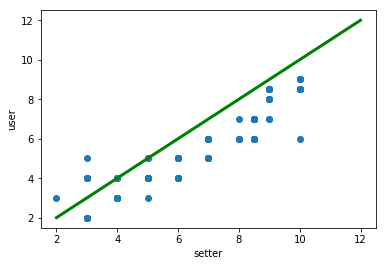

In [221]:
plt.scatter(user_diff['setter_vermin'], user_diff['user_vermin'])
plt.xlabel("setter")
plt.ylabel("user")
plt.plot([2,12],[2,12], color='g', linestyle='-', linewidth=3);

In [488]:
from bs4 import BeautifulSoup
import requests

url = "http://en.wikipedia.org/wiki/ISO_3166-1"
r = requests.get(url)
soup = BeautifulSoup(r.content, "lxml")

t = soup.findAll('table', {'class' : 'wikitable sortable'})[1]
L = []
cs = [th.findAll(text=True)[0] for th in t.findAll('th')]

for row in t.findAll("tr")[1:]:
    tds = row.findAll('td')
    raw_cols = [td.findAll(text=True) for td in tds]
    cols = []
    # country field contains differing numbers of elements, due to the flag -- 
    # only take the name
    cols.append(raw_cols[0][-1:][0])
    # for all other columns, use the first result text
    cols.extend([col[0] for col in raw_cols[1:]])
    L.append(cols)

countries = pd.DataFrame(L, columns=cs)
countries.head()

,English short name (upper/lower case),Alpha-2 code,Alpha-3 code,Numeric code,Link to,Independent
0,,AF,AFG,004,ISO 3166-2:AF,Yes
1,,AX,ALA,248,ISO 3166-2:AX,No
2,,AL,ALB,008,ISO 3166-2:AL,Yes
3,,DZ,DZA,012,ISO 3166-2:DZ,Yes
4,,AS,ASM,016,ISO 3166-2:AS,No


# Country Cleaning

In [22]:
df['country'] = df['country'].apply(lambda x: x.upper().strip())


In [56]:
len(df['country'].value_counts())

48

In [109]:
# COUNTRY DICTIONARY FOR CLEANING COUNTRY COLUMNS
country_dict = {
    "UNITED STATES OF AMERICA": ['USA','UNITED STATES','USA','US','AMERICA','NEW JERSEY','ARIZONA','UNIYED STATES',
                                'UNITED STATES OF AMAERICA','TEXAS','STATES','CALIFORNIA','QUEENS','UNITED STARTED',
                                'U.S.','U.S.A.','NY','NC','CO','WA','NEW YORK','IN','HAMILTON','DOUGLAS','EEUU','U.S.A'
                                ,'USS','UNITED STATES​'],
    "JAPAN": ['JJAJAPJAPAJAPANJAPANJAPAN','JPN','日本','JAPANN'],
    "GERMANY": ['DEUTSCHLAND', 'DE', 'GER','GERMAY','BERLIN','GERMMONEY','KARLSRUHE','SAARLAND','GERMANY​'],
    "CANADA": ['ALBERTA','CANDA','ON',"CAN"],
    "NORWAY": ['NORGE','NIRWAY','HERØY','NORWSY','NO'],
    "UNITED KINGDOM": ['UK','ENGLAND','YORKSHIRE', 'WEST YORKS','CUMBRIA','TYNE AND WEAR','WALES','GUERNSEY','MIDLOTHIAN',
                      'SOTLAND','WEST YORKSHIRE','SHROPSHIRE','TYNE & WEAR','GREAT BRITAIN','EDINBURGH','COTLAND','BRITAIN',
                      'FLINTSHIRE','LANARKSHIRE','CHESHIRE','ENGERLAND','IRELAND','SCOTLAND'],
    "ITALY": ['ITALIA','SONDRIO','PIEMONTE','PINEROLO','TRENTO'],
    "HONG KONG": ['HONGKONG', 'HK','HONG KONG SAR','HONG KONG SAR CHINA','SAR'],
    "SPAIN": ["ESPAÑA",'CATALUNYA','ESPAÑ','MURCIA','MADRID'],
    "SWITZERLAND": ['SUISSE','SCHWEIZ','SWIZERLAND','TREYVAUX'],
    "ROMANIA": ['ROMÂNIA'],
    "POLAND": ['POLSKA','PL'],
    "THE NETHERLANDS":['NEDERLAND','NL','NETHERLANDS'],
    "DENMARK": ["DANMARK"],
    "HUNGARY": ['MAGYARORSZÁG'],
    "CHILE": ['CH'],
    "SWEDEN": ['SVERIGE','SWEEDEN'],
    "BRAZIL": ['BRASIL'],
    "AUSTRALIA": ['AUS','AUSTRALIA​'],
    "AUSTRIA": ['ÖSTERREICH','VORARLBERG'],
    "RUSSIA": ['RUSS','RUS','RUSSIAN FEDERATION'],
    "SOUTH KOREA": ['REPUBLIK OF KOREA','YOSU','KR','KOREA']    
}
def country_text_cleaner(df):
    for row_no in range(len(df)): #iterate through each row

        if row_no % 100 == 0: print(row_no)

        for key in country_dict.keys(): # check each country name

            if df['country'][row_no] in country_dict[key]: # against the values it could be
                df['country'][row_no] = key # set if janky name in the values
    return df

In [60]:
df[df['country']=='BRAZIL']['city']

531    belo horizonte
532    belo horizonte
Name: city, dtype: object

In [110]:
df.groupby('country').mean().sort_values('target_vermin', ascending=False)['target_vermin']

country
SLOVENIA                    8.000000
GREECE                      6.750000
MEXICO                      6.666667
CHILE                       6.666667
MALAYSIA                    6.500000
SINGPORE                    6.384615
SOUTH KOREA                 6.119718
SINGAPORE                   5.984694
ISRAEL                      5.888889
RUSSIA                      5.650000
FRANCE                      5.535714
SPAIN                       5.521127
UNITED STATES OF AMERICA    5.480654
ITALY                       5.373264
BULGARIA                    5.352941
THE NETHERLANDS             5.243243
LUXEMBOURG                  5.235294
NETHERLANDS                 5.169811
SWITZERLAND                 5.117391
AUSTRIA                     5.065476
SWEDEN                      5.015625
CANADA                      4.997186
NORWAY                      4.994481
GERMANY                     4.855588
POLAND                      4.842857
UNITED KINGDOM              4.793088
AUSTRALIA                   4.

In [77]:
pd.get_dummies(df['country']) # steepness dummy col

# df = pd.concat([df,pd.get_dummies(df['method'], drop_first=True)], axis=1)

,ARGENTINA,AUSTRALIA,AUSTRIA,BELGIUM,BRAZIL,BULGARIA,CANADA,CHILE,CHINA,CROATIA,DENMARK,DISTRICT 51,FALKLAND ISLANDS,FINLAND,FRANCE,GERMANY,GREECE,GREENLAND,HONG KONG,HUNGARY,ISRAEL,ITALY,JAPAN,LUXEMBOURG,LUXEMBURG,MALAYSIA,MEXICO,NETHERLANDS,NEW ZEALAND,NORWAY,POLAND,ROMANIA,RUSSIA,SINGAPORE,SINGPORE,SLOVAKIA,SLOVENIA,SOUTH AFRICA,SOUTH KOREA,SPAIN,SWEDEN,SWITZERLAND,TAIWAN,THE NETHERLANDS,TURKEY,UKRAINE,UNITED KINGDOM,UNITED STATES OF AMERICA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [80]:
len(df['setter'].value_counts())

1984

In [136]:
len(df['city'].apply(lambda x: x.upper().strip()).value_counts())

710

In [118]:
df['country'].value_counts()

UNITED STATES OF AMERICA    3670
UNITED KINGDOM              1143
JAPAN                        884
GERMANY                      689
CANADA                       533
NORWAY                       453
ITALY                        288
SOUTH KOREA                  213
AUSTRALIA                    193
SWEDEN                       128
SWITZERLAND                  115
SINGAPORE                     98
HONG KONG                     98
THE NETHERLANDS               90
AUSTRIA                       84
SPAIN                         71
POLAND                        70
DENMARK                       49
CHINA                         43
FALKLAND ISLANDS              37
LUXEMBOURG                    35
FRANCE                        28
ROMANIA                       27
TAIWAN                        20
RUSSIA                        20
GREECE                        18
TURKEY                        17
BULGARIA                      17
FINLAND                       16
SINGPORE                      13
NEW ZEALAN

In [114]:
countries_greater_20 = list(df['country'].value_counts().head(26).index)
countries_greater_20

['UNITED STATES OF AMERICA',
 'UNITED KINGDOM',
 'JAPAN',
 'GERMANY',
 'CANADA',
 'NORWAY',
 'ITALY',
 'SOUTH KOREA',
 'AUSTRALIA',
 'SWEDEN',
 'SWITZERLAND',
 'SINGAPORE',
 'HONG KONG',
 'THE NETHERLANDS',
 'AUSTRIA',
 'SPAIN',
 'POLAND',
 'DENMARK',
 'CHINA',
 'FALKLAND ISLANDS',
 'LUXEMBOURG',
 'FRANCE',
 'ROMANIA',
 'RUSSIA',
 'TAIWAN',
 'GREECE']

In [96]:
top_countries = []
for row in range(len(df)):
    if df['country'][row] in countries_greater_20:
        top_countries.append(df['country'][row])
    else:
        top_countries.append(None)

In [98]:
df['top_countries'] = top_countries

In [106]:
df[['country','top_countries']]

,country,top_countries
0,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA
1,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA
2,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA
3,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA
4,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA
5,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA
6,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA
7,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA
8,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA
9,UNITED STATES OF AMERICA,UNITED STATES OF AMERICA


In [223]:
temp_df = df[(df['target_vermin']>=9)]

In [226]:
#USED FOR MAKING HOLD FREQUENCY HEATMAPS
holds_list = [] # Create a list of A1 - K18
    
for x in range(0,198):
    num = x % 18 + 1
    alph = chr(x // 18 + 65)
    holds_list.append(f"{alph}{num}")
    
holds_array = np.zeros((18,11))  


for hold in holds_list:
    
    holds_array[18-int(hold[1:])][ord(hold[0])-65] = temp_df[hold].sum()
    print(f"{hold}: {temp_df[hold].sum()}")

A1: 2
A2: 1
A3: 15
A4: 8
A5: 17
A6: 4
A7: 1
A8: 15
A9: 19
A10: 6
A11: 10
A12: 4
A13: 16
A14: 2
A15: 22
A16: 4
A17: 1
A18: 62
B1: 1
B2: 14
B3: 7
B4: 17
B5: 13
B6: 38
B7: 15
B8: 32
B9: 16
B10: 14
B11: 9
B12: 11
B13: 13
B14: 15
B15: 11
B16: 14
B17: 9
B18: 35
C1: 1
C2: 8
C3: 14
C4: 40
C5: 41
C6: 10
C7: 5
C8: 36
C9: 20
C10: 9
C11: 11
C12: 8
C13: 16
C14: 4
C15: 39
C16: 6
C17: 10
C18: 35
D1: 17
D2: 8
D3: 33
D4: 6
D5: 30
D6: 13
D7: 13
D8: 19
D9: 14
D10: 5
D11: 58
D12: 33
D13: 27
D14: 13
D15: 15
D16: 18
D17: 19
D18: 61
E1: 4
E2: 15
E3: 18
E4: 33
E5: 24
E6: 13
E7: 8
E8: 6
E9: 26
E10: 7
E11: 25
E12: 19
E13: 11
E14: 39
E15: 30
E16: 1
E17: 14
E18: 17
F1: 4
F2: 17
F3: 28
F4: 12
F5: 27
F6: 20
F7: 15
F8: 3
F9: 8
F10: 48
F11: 44
F12: 14
F13: 27
F14: 22
F15: 6
F16: 52
F17: 13
F18: 80
G1: 4
G2: 8
G3: 20
G4: 19
G5: 21
G6: 27
G7: 36
G8: 19
G9: 29
G10: 23
G11: 5
G12: 24
G13: 35
G14: 17
G15: 22
G16: 25
G17: 2
G18: 55
H1: 11
H2: 12
H3: 20
H4: 32
H5: 15
H6: 44
H7: 19
H8: 7
H9: 22
H10: 7
H11: 32
H12: 18
H13: 23

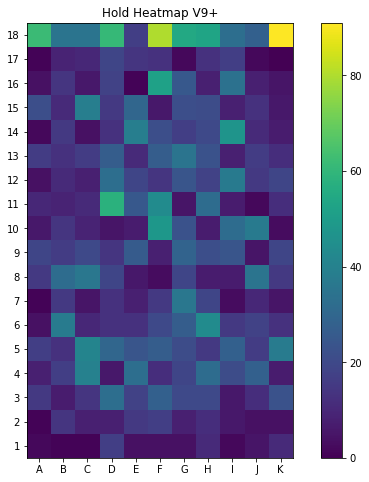

In [225]:
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111)
ax.set_title('Hold Heatmap V9+')
plt.imshow(holds_array)
ax.set_aspect('equal')

plt.xticks(range(0,11),['A',"B","C","D","E","F","G","H","I","J","K"])
plt.yticks(range(0,18),range(18,0,-1))

plt.colorbar(orientation='vertical')

plt.savefig('Adv_holds')

In [283]:
re.findall(r'\d+', str(df[df['problem_name'] == 'WARM UP ON BIG ONES']['move_coords']))

['711', '245', '236', '295', '588', '345', '386', '395', '338', '445', '486']

In [282]:
df[df['problem_name'] == 'WARM UP ON BIG ONES']['move_coords']

711    [[245, 236], [295, 588], [345, 386], [395, 338], [445, 486]]
Name: move_coords, dtype: object

In [284]:
moves_coords = [(345, 736),(345, 86),(245, 236), (295, 588), (345, 386), (395, 338),(445, 486)]

In [285]:
#Creates a representation of the KDTree

from collections import namedtuple
from operator import itemgetter
from pprint import pformat

class Node(namedtuple('Node', 'location left_child right_child')):
    def __repr__(self):
        return pformat(tuple(self))

def kdtree(point_list, depth=0):
    try:
        k = len(point_list[0]) # assumes all points have the same dimension
    except IndexError as e: # if not point_list:
        return None
    # Select axis based on depth so that axis cycles through all valid values
    axis = depth % k
 
    # Sort point list and choose median as pivot element
    point_list.sort(key=itemgetter(axis))
    median = len(point_list) // 2 # choose median
 
    # Create node and construct subtrees
    return Node(
        location=point_list[median],
        left_child=kdtree(point_list[:median], depth + 1),
        right_child=kdtree(point_list[median + 1:], depth + 1)
    )

def main():
    """Example usage"""
    point_list = [(345, 736),(345, 86),(245, 236), (295, 588), (345, 386), (395, 338),(445, 486)]
    tree = kdtree(point_list)
    print(tree)

if __name__ == '__main__':
    main()

((345, 86),
 ((295, 588), ((245, 236), None, None), ((345, 736), None, None)),
 ((345, 386), ((395, 338), None, None), ((445, 486), None, None)))
